# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [28]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image.

Let's start with gray tones first.

Using the colour pallette, let's quantize the original image.

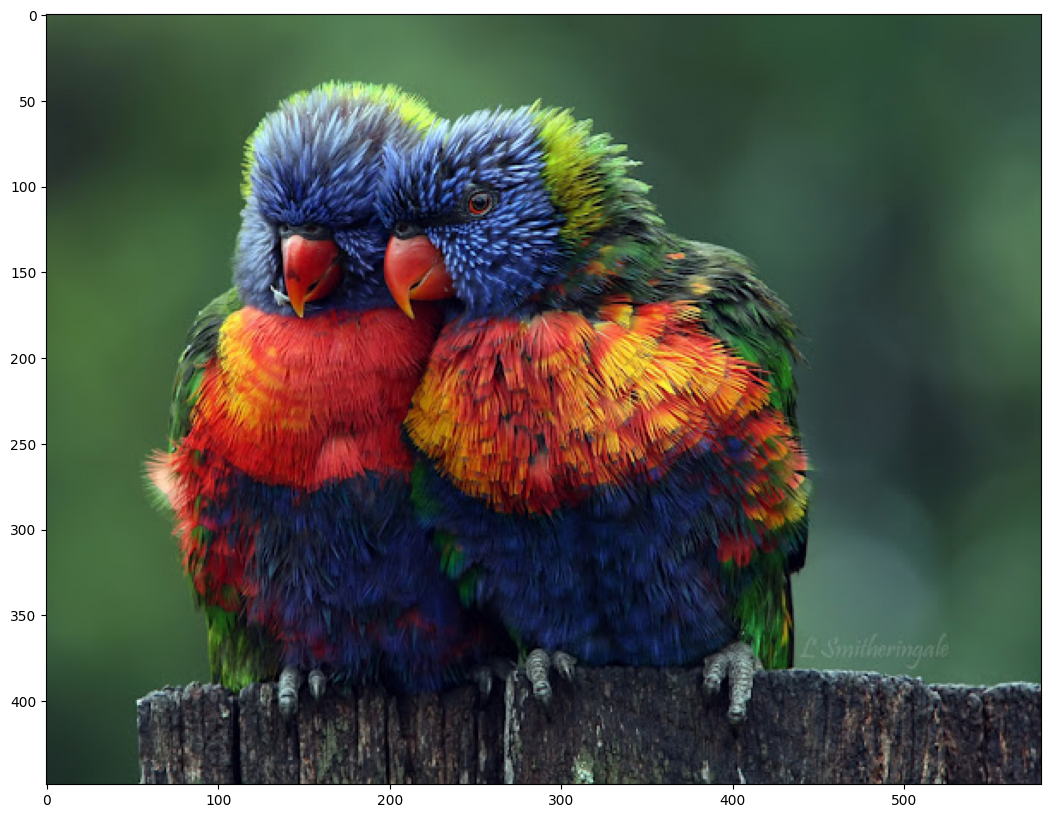

In [349]:
def distances_between(array, value):
    distances = np.zeros(len(array), dtype=np.float32)
    for i in range(0, len(array)):
        distances[i] = np.linalg.norm(array[i] - value)
    return distances

# Load image

image_name = 'parrots'
extension = 'jpeg'

img = cv2.imread(f'data/{image_name}.{extension}')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

number_of_colors = 256

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=number_of_colors).fit(np.reshape(img, (-1, 3)))
colors = kmeans.cluster_centers_

img = img / 255
palette = np.array(colors, dtype=np.float32)
palette = palette / 255

# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)

# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r, c, :]

        distances = distances_between(palette, pixel)

        min_index = np.argmin(distances)
        new_pixel = palette[min_index]
        quantized[r, c, :] = new_pixel


0.00027283744


(<Axes: >, <matplotlib.image.AxesImage at 0x2d6c5fd50>)

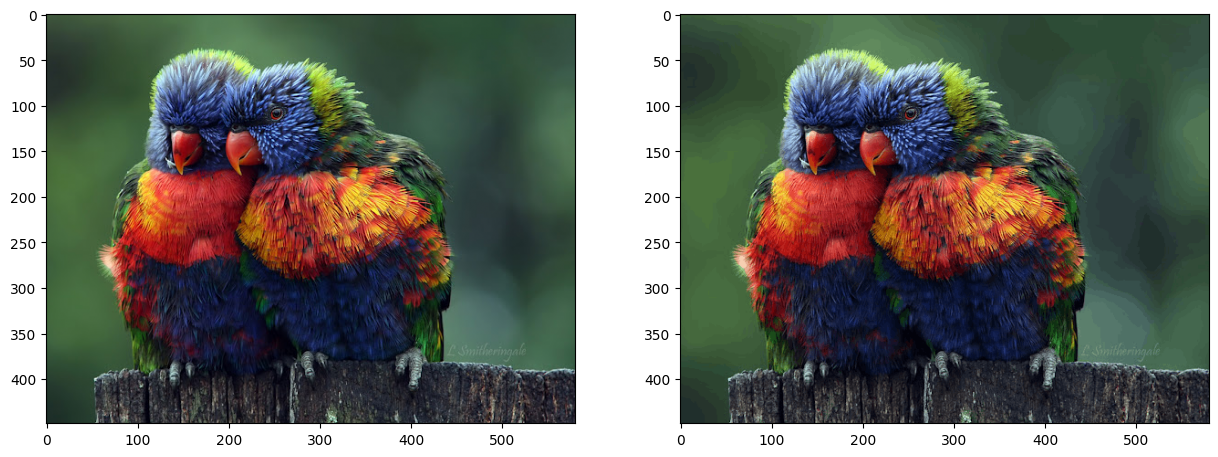

In [350]:
def mse(ref, target):
    error = ref.astype(np.float32) - target.astype(np.float32)
    return np.mean(error**2)

# Compute average quantization error
avg_quant_error = mse(quantized, img)
print(avg_quant_error)

quantized = np.uint8(quantized * 255)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(quantized)


#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [351]:
# Make a temporal copy of the original image, we will need it for error diffusion
img_tmp = np.copy(img)
dithering = np.zeros_like(img)
rows, cols, channels = img.shape

for r in range(1, rows-1):
    for c in range(1, cols-1):
        # Extract the original pixel value
        pixel = img_tmp[r, c, :]
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)

        distances = np.zeros(len(palette))
        for i in range(0, len(palette)):
            distances[i] = np.linalg.norm(palette[i] - pixel)

        min_index = np.argmin(distances)
        new_pixel = palette[min_index]
        
        # Compute quantization error
        quant_error = pixel - new_pixel
        
        # Diffuse the quantization error accroding to the FS diffusion matrix
        # Note: You may need more than one line of code here
        img_tmp[r + 1, c] = img_tmp[r + 1, c] + quant_error * 7/16
        img_tmp[r - 1, c + 1] = img_tmp[r - 1, c + 1] + quant_error * 3/16
        img_tmp[r, c + 1] = img_tmp[r, c + 1] + quant_error * 5/16
        img_tmp[r + 1, c + 1] = img_tmp[r + 1, c + 1] + quant_error * 1/16
        
        # Apply dithering
        dithering[r, c] = new_pixel

0.0009825582
uint8


True

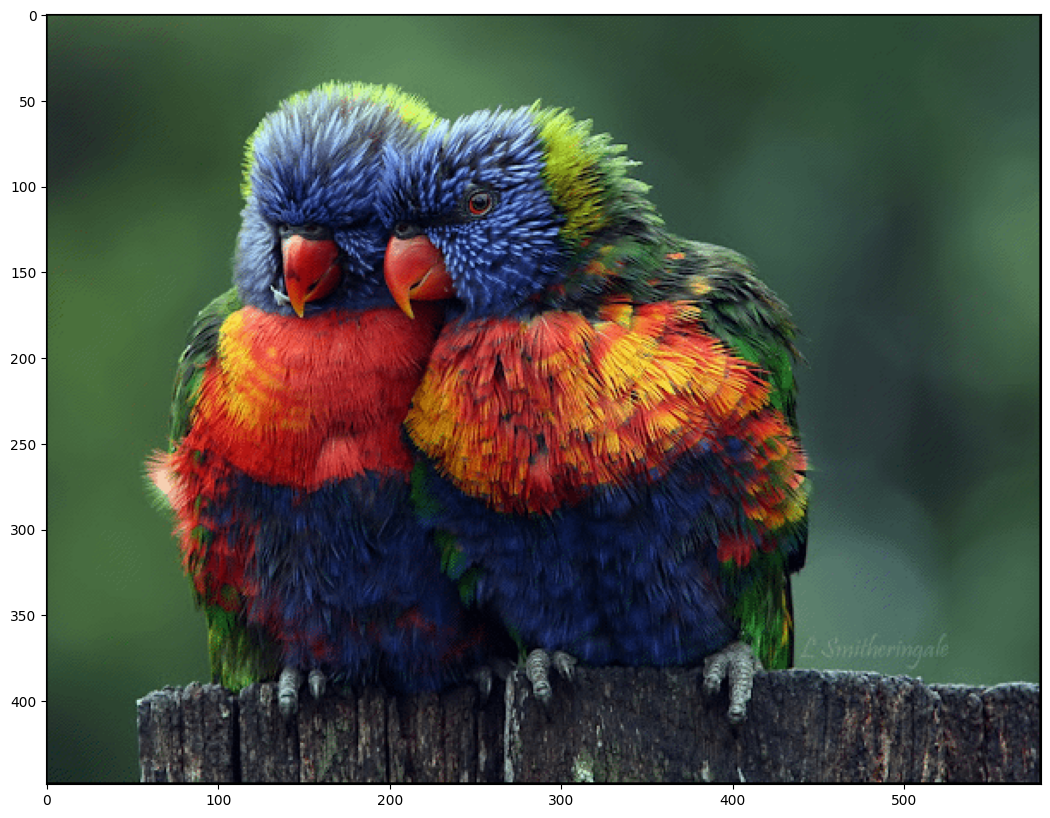

In [352]:
# Compute average quantization error for dithered image
avg_dith_error = mse(img, dithering)
print(avg_dith_error)

dithering = dithering * 255.0
dithering[dithering > 255] = 255
dithering = np.uint8(dithering)

print(dithering.dtype)
# plt.subplot(121), plt.imshow(quantized, cmap='gray')   # optimally quantized
plt.imshow(dithering)   # dithering

im_bgr = cv2.cvtColor(dithering, cv2.COLOR_RGB2BGR)

cv2.imwrite(f'results/{image_name}_rgb-fsd_{number_of_colors}.{extension}', im_bgr)

### Questions
* Which image has higher quantization error? Optimally quantized or dithered?
* Which image looks better to you?
* Can you repeat the same process using only two colours: black and white? Show me :-)

### Answers

## Which image has higher quantization error? Optimally quantized or dithered?

Suprisingly, optimally quantized method has less mean square error than dithering.



| image  | Optimally quantized  | Floyd-Steinberg dithering  |
|---|---|---|
|kodim02   | 0.014922306  | 0.037883375  |
|kodim05   | 0.012725099  | 0.022532323  |
|kodim23   | 0.017865708  | 0.03283228   |
|puppy.jpeg   | 0.020481063  | 0.035791274  |
 


## Which image looks better to you?

Deffinitely dithering. It handles gradients pretty good and also visible edges are preserved.


| Floyd-Steinberg     | Optimally quantized |
| ----------- | ----------- |
| ![alt text](results/kodim02-fsd.png "Kodim02")    | ![alt text](results/kodim02-quant.png "Kodim02")       |
| ![alt text](results/kodim05-fsd.png "Kodim02")    | ![alt text](results/kodim05-quant.png "Kodim02")       |
| ![alt text](results/kodim23-fsd.png "Kodim02")    | ![alt text](results/kodim23-quant.png "Kodim02")       |
| ![alt text](results/puppy-fsd.png "Kodim02")      | ![alt text](results/puppy-quant.png "Kodim02")       |


## Can you repeat the same process using only two colours: black and white? Show me :-)

| Floyd-Steinberg     | Optimally quantized |
| ----------- | ----------- |
| ![alt text](results/kodim02_bw-fsd.png "Kodim02")    | ![alt text](results/kodim02_bw-quant.png "Kodim02")       |
| ![alt text](results/kodim05_bw-fsd.png "Kodim02")    | ![alt text](results/kodim05_bw-quant.png "Kodim02")       |
| ![alt text](results/puppy_bw-fsd.png "Kodim02")      | ![alt text](results/puppy_bw-quant.png "Kodim02")       |

### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16).fit(np.reshape(img, (-1, 1)))
colors = kmeans.cluster_centers_

Apply FS dithering the same way you did before.
* How does the result look like to you?
* What happens if we use 32 colours?
* And what happens if we use 256 colours?

# How does the result look like to you?

The larger the palette size, the less visual differences can be seen between the original and dithered image. Also depends on image format. Dithering produces really good results for png images, for jpeg it produces larger size images. 

|  Original image | Image size  | Dithered image  | Image size  | Number of colors  | Execution time, sec  |
|---|---|---|---|---|---|
| ![alt text](data/kodim23.png "Kodim23")  | 618KB  | ![alt text](results/kodim23_rgb-fsd_16.png "Kodim23")  | 474KB  | 16  | 14.1  |
| ![alt text](data/kodim23.png "Kodim23")  | 618KB  | ![alt text](results/kodim23_rgb-fsd_32.png "Kodim23")  | 509KB  | 32  | 15.8  |
| ![alt text](data/kodim23.png "Kodim23")  | 618KB  | ![alt text](results/kodim23_rgb-fsd_256.png "Kodim23")  | 585KB  | 256  | 200  |
| ![alt text](data/parrots.jpeg "Parrots")  | 95KB  | ![alt text](results/parrots_rgb-fsd_16.jpeg "Parrots")  | 149KB  | 16  | 9.5  |
| ![alt text](data/parrots.jpeg "Parrots")  | 95KB  | ![alt text](results/parrots_rgb-fsd_32.jpeg "Parrots")  | 146KB  | 32  | 15.8  |
| ![alt text](data/parrots.jpeg "Parrots")  | 95KB  | ![alt text](results/parrots_rgb-fsd_256.jpeg "Parrots")  | 122KB  | 32  | 106  |

